# Generating CFPy-ready network structures with pyKasso

# 1. Getting started

### 1.1. Install pyKasso
First, please go to the [GitHub page of pyKasso](https://github.com/randlab/pyKasso) and follow the instructions to install pyKasso.

### 1.2. Import packages
Import all necessary packages for this tutorial

In [1]:
import CFPy as cfpy
import pykasso as pk
import matplotlib.pyplot as plt
import numpy as np

### 1.3. Show Versions
It is helpful to always print out the versions of the respective packages before using them

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-08-29T09:02:56.545713+02:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 4, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

numpy     : 1.22.4
matplotlib: 3.5.2
CFPy      : 0.1
pykasso   : 0.1.0



# 2. Generating network structures with pyKasso

PyKasso is a stochastic network generator based on a `Fast Marching Algorithm`. The assumption is that karst evolution will develop in such a way that water takes a minimum-efford path in creating karst conduits. The efford is termed `Travel Cost` and depends on the geology. For example, fractures would have a lower Travel Cost than rigid sandstone and it is therefore more likely that water will travel the fractured way and create karst conduits there over time. Given a map of the geology as well as `Inlets` and `Outlets` in the karst aquifer a Fast Marching Algorithm computes the paths between Inlets and Outlets with minimum Travel Costs which then are being taken as conduits. Together the conduits form a conduit network. A more detailed explanation can be found in the [pyKasso Publication](https://www.doi.org/10.1007/s10040-022-02464-x).

All information about the karst aquifer that is necessary to create a conduit network is provided in a settings file. Please have a look into the [settings file for this example](settings.yaml). There you find the explanations for each option.
Our settings file is set up in such a way that ....
- the karst aquifer is 1000m x 1000m with a resolution of 10m x 10m
- one `Outlet` is located at x=505m and y=0m
- 10 `Inlets` are randomly created
- 2 fracture types are randomly generated with individual densities and orientations 

### 2.1. Instantiate the SKS object

At first, the Stochastic Karst Simulator (SKS) object is generated by providing the settings file. This object holds all input information of the settings file and all methods needed, such as visualizations and most importantly the creation of a conduit network.

In [5]:
# create a catchment from the information given in settings.yaml
catchment = pk.SKS(yaml_settings_file="settings.yaml")

CAUTION: You are using the development version of this package.


### 2.2. Investigate input data

You can access input information the SKS object holds with `get` methods. Besides, you can plot input information using the method `show_catchment()` and providing the data type as argument.

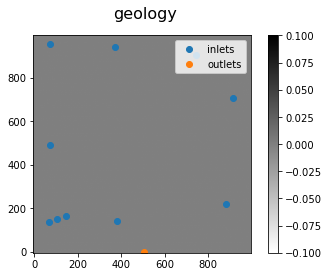

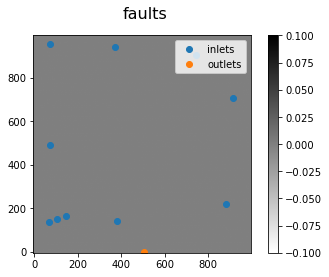

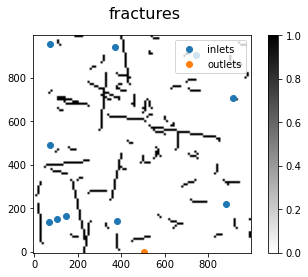

In [6]:
# get data for geology, faluts, and fractures as arrays
geology = catchment.get_geology()
faults = catchment.get_faults()
fractures = catchment.get_fractures()

# show maps of geology, faults, and fractures
catchment.show_catchment(data='geology')
catchment.show_catchment(data='faults')
catchment.show_catchment(data='fractures')

### 2.3. Compute the conduit network

To compute the conduit network based on the input information call the method `compute_karst_network()`. You can visualise the network with the `show()` method.


 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


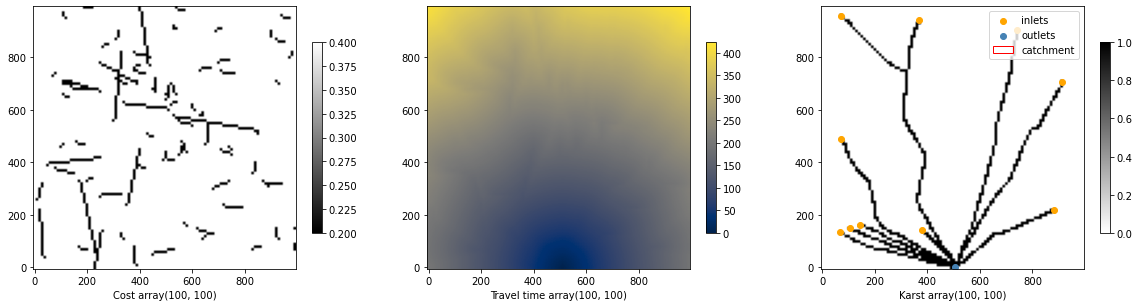

In [7]:
# compute karst networks from the given information
catchment.compute_karst_network()

# show the result of the last iteration (the last karst network)
# probability = True is not supported
catchment.show(probability=False)

# 3. Implementing network structures to CFPy

### 3.1. Validation of network structure

The network generated by pyKasso needs to be validated in order to be used in CFPy. This is because in pyKasso it is assumed that diaginally adjacent nodes are **connected**; in MODFLOW-CFP, however, diagonally adjacent nodes are considered to be **not connected**
        
It is checked whether instances of \
        $ \left[ \begin{array}{rrrr} \ddots & & & \\ & 1 & 0 & \\ & 0 & 1 & \\ & & & \ddots \end{array} \right] $ or $ \left[ \begin{array}{rrrr} \ddots & & & \\ & 0 & 1 & \\ & 1 & 0 & \\ & & & \ddots \end{array} \right] $ \
        are present in the network (a $ 0 $ signals a matrix cell and a $ 1 $ signals a network node)

If such instances are present, they are altered by randomly adding an additional node in one of the possible positions, e.g., \
        $ \left[ \begin{array}{rrrr} \ddots & & & \\ & 1 & \color{red}{0} & \\ & 0 & 1 & \\ & & & \ddots \end{array} \right] \rightarrow \left[ \begin{array}{rrrr} \ddots & & & \\ & 1 & \color{red}{1} & \\ & 0 & 1 & \\ & & & \ddots \end{array} \right] $



In [8]:
# generate elevation data (providing elevation data for the nodes is optional)
# NOTE: elevation data has to have the same shape as the node network array!
# here, a uniform elevation of 125.0 [L] is assumed for the node plane
elevs = np.ones_like(np.array(catchment.karst_simulations[-1].maps['karst'][-1])) * 125.

# validate the network from pyKasso
validator = cfpy.preprocessing.pyKassoValidator(network=catchment, elevations=elevs)
valid_network = validator.validate_network()


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


### 3.2. Generation of .nbr-file

Now the validated network is saved in the .nbr file for CFPy

In [9]:
nrows = catchment.get_ynum()
ncols = catchment.get_xnum()

validator.generate_nbr(nrows=nrows, ncols=ncols, nlays=1, layer_elevations=[[1000.], [0.]])

The validated network can be plotted

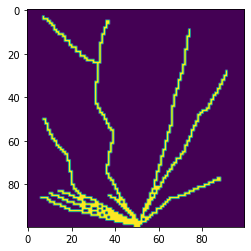

In [10]:
# plot the network
plt.imshow(valid_network)

### 3.3. Export network

The validated network can further be exported to a seperate .txt file. This file can later be available for the .nbr file.

In [11]:
validator.export_network()